In [1]:
import os 
import numpy as np
import healpy as hp
import sys
import broom

import matplotlib.pyplot as plt
import pymaster as nmt

from broom import (
    Configs,
    get_params, _compute_spectra,
    component_separation,_get_full_simulations, estimate_residuals, _combine_products)
from broom._needlets import _get_needlet_windows_
from broom.clusters import get_and_save_real_tracers_B

from matplotlib.legend_handler import HandlerTuple
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
import matplotlib.ticker as tck

root_path = os.path.dirname(os.path.abspath(broom.__file__))


## 🧪 Tutorial: Component Separation for Ground-Based Experiments

In this notebook, we demonstrate how to perform **component separation** and compute **angular power spectra**  
for **ground-based experiments**. The focus is on highlighting the key differences compared to the **satellite-based** case.

### Introduction to Configuration Parameters

See `configs/config_demo.yaml` and the notebook `tutorial_satellite.ipynb` in the `broom`  package for a detailed explanation of all parameters.

---

### Tutorial: Simulations Generation

An other example of simulations generation is provided in the notebook:  
`tutorial_satellite.ipynb`

### Tutorial: Component Separation

Learn how to perform component separation using:  
- `tutorial_satellite.ipynb`
- `tutorial_satellite_v2.ipynb`

### Tutorial: Power spectrum estimation

Learn how to compute angular power spectra using:
- `tutorial_spectra.ipynb`  




In [2]:
# Importing all general parameter from ground-based experiment config file
# experiment: SO_SAT,
# foreground model: d1s1
# data_type: "maps"

config_path = root_path + "/configs/config_groundbased.yaml"

config: Configs = get_params(config_path=config_path)
print("Loaded configuration from\n", config_path)

Loaded configuration from
 /home/alecarones/anaconda3/envs/test_install_11/lib/python3.11/site-packages/broom/configs/config_groundbased.yaml


In [5]:
# It will use hits maps stored in utils of broom package to generate noise simulations
config.instrument.path_hits_maps = os.path.join(root_path, "utils", "norm_nHits_SA_35FOV_ns512.fits")

In [7]:
# Generating input simulations for SO_SAT experiment

data = _get_full_simulations(config, nsim = 0)


Generating foreground maps of d1s1 model


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating CMB simulation 00000
Generating noise simulation 00000
Generating coadded signal for simulation 00000


/home/alecarones/anaconda3/envs/test_install_11/lib/python3.11/site-packages/broom/simulations.py:431: RuntimeWarning: divide by zero encountered in power
  N_ell *= (1 + (ell / config.instrument.ell_knee[nf]) ** config.instrument.alpha_knee[nf])
/home/alecarones/anaconda3/envs/test_install_11/lib/python3.11/site-packages/broom/simulations.py:431: RuntimeWarning: invalid value encountered in multiply
  N_ell *= (1 + (ell / config.instrument.ell_knee[nf]) ** config.instrument.alpha_knee[nf])
/home/alecarones/anaconda3/envs/test_install_11/lib/python3.11/site-packages/broom/simulations.py:458: RuntimeWarning: divide by zero encountered in divide
  noise_map = hp.alm2map(alm_noise, config.nside, lmax=config.lmax, pol=True) / np.sqrt(hits_map)


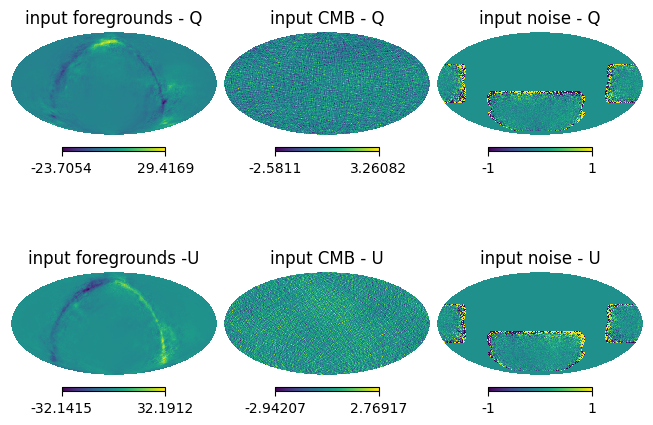

In [9]:
# Let's inspect e.g. QU inputs at a specific frequency channel

freq_idx = 2

plt.figure()
hp.mollview(data.fgds[freq_idx,1], title="input foregrounds - Q", sub=(2,3,1))
hp.mollview(data.cmb[freq_idx,1], title="input CMB - Q", sub=(2,3,2))
hp.mollview(data.noise[freq_idx,1], title="input noise - Q", sub=(2,3,3), max=1., min=-1.)

hp.mollview(data.fgds[freq_idx,2], title="input foregrounds -U", sub=(2,3,4))
hp.mollview(data.cmb[freq_idx,2], title="input CMB - U", sub=(2,3,5))
hp.mollview(data.noise[freq_idx,2], title="input noise - U", sub=(2,3,6), max=1., min=-1.)

# 


## Component separation

Let's apply NILC component separation on simulated data

In [10]:
# ILC in needlet domain (NILC) with cosine needlets

config_run = {
    'compsep': [{
    'method': "ilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    # Needlet configuration
    'needlet_config':
      [{'needlet_windows': "cosine"},
       {'ell_peaks': [0,100,200,250]}],
    'reduce_ilc_bias': False,
    'b_squared': False,
    'save_needlets': True,
    'save_weights': True,
    'cov_noise_debias': [0.,0.,0.,0.]
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes


In [11]:
# If field_out is "QU", NILC will be applied separately on E- and B-modes 
# and then recombine compsep outputs into QU
config.field_out = "QU"

# Defining the mask associated to observations (it should be apodized in case of leakage correction with purification)
# All pixels not observed by the instrument should be 0 in this mask.
config.mask_observations = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
# mask_covariance is applied to maps to weigh differently pixels in covariance computation and therefore in compsep
# If some pixels are not 0 in mask_covariance but 0 in mask_observations, they will be masked.
config.mask_covariance = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #


In [12]:
# In this case EB-leakage is not corrected and 
# input alms are computed from input maps simply masked with loaded mask_observations (made binary)

config.leakage_correction = None

outputs_nilc_noleak = component_separation(config, data, nsim = 0)

Computing required input alms for component separation for simulation 00000.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running ilc in needlet domain for simulation 00000.


/home/alecarones/anaconda3/envs/test_install_11/lib/python3.11/site-packages/broom/_inputs.py:450: RuntimeWarning: divide by zero encountered in divide
  pixwin_inv = 1. / np.array(hp.pixwin(config.nside_in, pol=True, lmax=config.lmax))
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


In [13]:
# In this case EB-leakage is corrected with standard purification technique (only in B-modes).
# If you want to purify also E-modes, leakage_correction should be 'EB_purify'
# Note that output products will be returned apodized 
# This should be take into account when computing spectra 
# (for spectra computation you should provide the binary mask, see cells below)

config.leakage_correction = "B_purify"

outputs_nilc_pure = component_separation(config, data, nsim = 0)

Computing required input alms for component separation for simulation 00000.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


In [14]:
# In this case EB-leakage is corrected with recycling technique 
# with three iterations (only in B-modes).
# See https://arxiv.org/abs/2208.12059 for details

config.leakage_correction = "B_recycling_iterations3"

outputs_nilc_rec = component_separation(config, data, nsim = 0)

Computing required input alms for component separation for simulation 00000.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


## Computation of power spectra

In [16]:
# Global parameters for power spectrum computation

config_cls_values = {
    'delta_ell': 10, 
    'spectra_comp': 'namaster',
    'return_Dell': False, 
    'field_cls_out': "BB", # Let's compute only B-mode power spectrum
    'return_spectra': True, 
    'save_spectra': True,  
    'save_mask': False,
}

config.config.update(config_cls_values)
config._store_passed_settings()   # refresh all dependent attributes


In [18]:
root_path

'/home/alecarones/anaconda3/envs/test_install_11/lib/python3.11/site-packages/broom'

In [19]:
# Creating binary mask for masking the outputs returned by compsep when inputs have been purified.
# The reason of using a binary mask is that returned outputs are already apodized during purification.
# This apodization is taken properly into account when 
# computing the coupling matrix in NaMaster or correcting for fsky in anafast

config.mask_observations = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
config.mask_covariance = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #

mask_ = hp.read_map(config.mask_observations,field=0)
mask_ /= np.max(mask_)
hp.write_map(root_path+"/utils/norm_nHits_SA_35FOV_ns512_binary.fits", np.ceil(mask_), overwrite=True)

setting the output map dtype to [dtype('float32')]


In [26]:
# Adopting the mask loaded from fits file specified in mask_path which is equal to mask_observations (or its binary)
# Requiring purification of B-modes from Namaster. If 'spectra_comp' is anafast purification is not performed.
# Note binary mask for 'B_purify' case
# but you can also use non-binary mask (but in this case effective sky fraction will be lower)

config_cls_run = {
    'compute_spectra': [{'path_method': "ilc_needlet_bias0.001/cosine_0_100_200_250",
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"],
    'mask_type': "from_fits", 'field_out': 'QU', 'mask_path':root_path+"/utils/norm_nHits_SA_35FOV_ns512.fits",
    'apodize_mask': None, 'smooth_mask': 0., 'nmt_purify_B': True,
    'nmt_purify_E': False,
    },
                
    {'path_method': "ilc_needlet_bias0.001_Bpurify/cosine_0_100_200_250",
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"],
    'mask_type': "from_fits", 'field_out': 'QU', 'mask_path':root_path+"/utils/norm_nHits_SA_35FOV_ns512_binary.fits",
    'apodize_mask': None, 'smooth_mask': 0., 'smooth_tracer': 10., 'fsky': 0.5, 'nmt_purify_B': True,
    'nmt_purify_E': False
    },
    
    {'path_method': "ilc_needlet_bias0.001_Brecycling_iters3/cosine_0_100_200_250",
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"],
    'mask_type': "from_fits", 'field_out': 'QU', 'mask_path':root_path+"/utils/norm_nHits_SA_35FOV_ns512.fits",
    'apodize_mask': None, 'smooth_mask': 0., 'smooth_tracer': 10., 'fsky': 0.5, 'nmt_purify_B': True,
    'nmt_purify_E': False
    }
    ]}

config.config["compute_spectra"] = config_cls_run["compute_spectra"]
config._store_passed_settings()   # refresh all dependent attributes
config.mask_observations = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
config.mask_covariance = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #


In [27]:
# Let's compute the spectra

cls_out = _compute_spectra(config)

print(f'Attributes of "cls_out" are {", ".join(vars(cls_out).keys())}')

# Shape corresponds to (n_sims, n_cases, n_fields, n_bins)
print(f'Shape of each attribute is {cls_out.fgds_residuals.shape}')

Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Output maps are weighted by config mask. This will be taken into account.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Attributes of "cls_out" are output_total, noise_residuals, fgds_residuals, output_cmb
Shape of each attribute is (1, 3, 1, 25)


In [28]:
# Let's import and bin the theoretical power spectrum
b_bin = nmt.NmtBin.from_lmax_linear(config.lmax, nlb=config.delta_ell, is_Dell=config.return_Dell)  
ell = np.arange(config.lmax+1)

field = 2 # we asked for BB spectrum

cls_r0 = hp.read_cl(root_path + '/utils/Cls_Planck2018_lensed_r0.fits')
cls_r0 = cls_r0[field,:config.lmax+1]
cls_r0 = b_bin.bin_cell(cls_r0)

cls_r1 = hp.fitsfunc.read_cl(root_path + '/utils/Cls_Planck2018_tensor_r1.fits')
cls_r1_BB = cls_r1[2,:config.lmax+1]
cls_r1_BB = b_bin.bin_cell(cls_r1_BB)

ell_bin = b_bin.get_effective_ells()


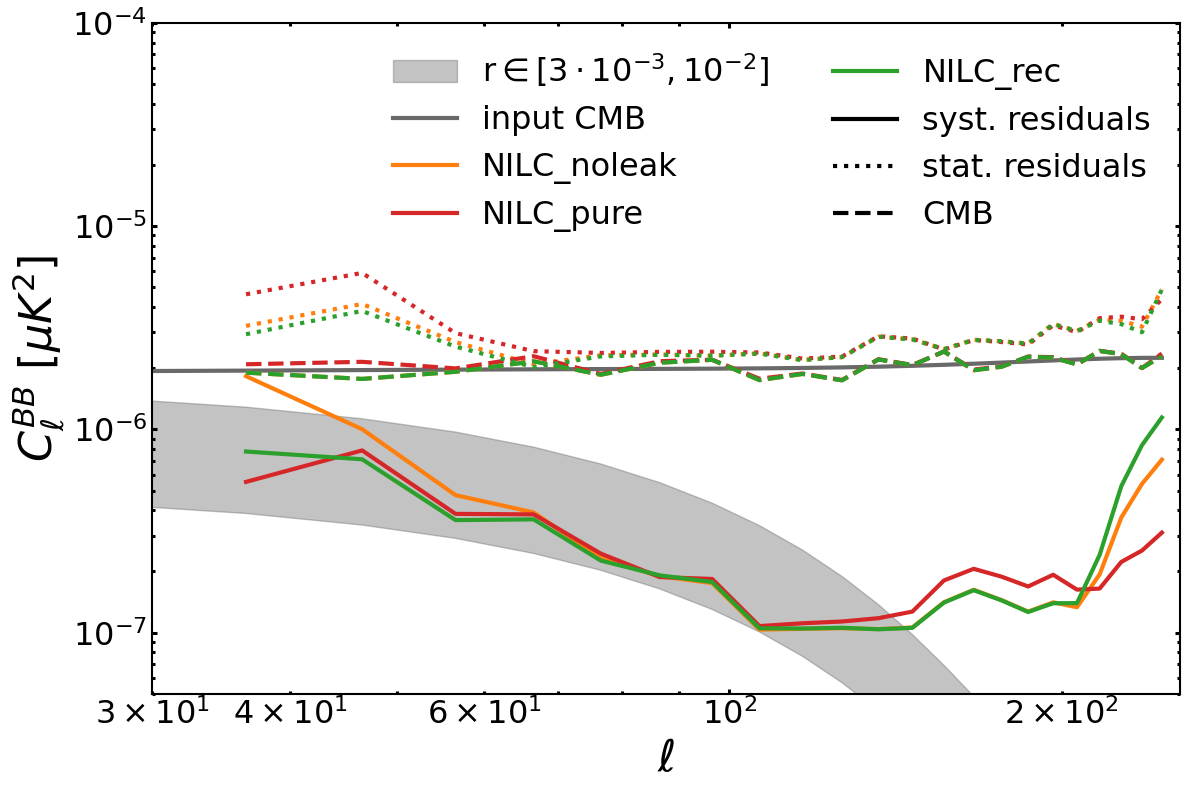

In [29]:
field=0
bmin=3 # we plot spectrum from ell=30

fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel("$\ell$", fontsize=32)
plt.ylabel("$C_{\ell}^{BB}\ [\mu K^{2}]$", fontsize=32)

plt.ylim(5e-8, 1e-4)
plt.xlim(30,config.lmax)

plt.fill_between(ell_bin,0.003*cls_r1_BB,0.01*cls_r1_BB,color='dimgrey',alpha=0.4,label=r'r$\in [3\cdot 10^{-3},10^{-2}]$')

cols=['C1','C3','C2','C4','C5','C6']
labs=['NILC_noleak','NILC_pure','NILC_rec']
p=plt.plot(ell_bin, cls_r0,linewidth=3.,label='input CMB',color='dimgrey')
for k in range(cls_out.output_total.shape[1]):
#     p=plt.plot(ell_bin[bmin:], np.mean(cls_out.output_total[:,k,field,bmin:],axis=0),linewidth=3.,label=labs[k],color=cols[k])
    p=plt.plot(ell_bin[bmin:], np.mean(cls_out.output_cmb[:,k,field,bmin:],axis=0),linewidth=3.,color=cols[k], linestyle='--')
    p=plt.plot(ell_bin[bmin:], np.mean(cls_out.fgds_residuals[:,k,field,bmin:],axis=0),linewidth=3.,label=labs[k],color=cols[k], linestyle='-')
    p=plt.plot(ell_bin[bmin:], np.mean(cls_out.noise_residuals[:,k,field,bmin:],axis=0),linewidth=3., linestyle=':',color=plt.gca().lines[-1].get_color())
    
plt.plot(ell_bin,-0.01*cls_r1_BB,color='k', label='syst. residuals',linewidth=3.)
plt.plot(ell_bin,-0.01*cls_r1_BB,color='k', linestyle=':', label='stat. residuals',linewidth=3.)
plt.plot(ell_bin,-0.01*cls_r1_BB,color='k', linestyle='--', label='CMB',linewidth=3.)

plt.legend(loc='upper right',ncol=2,fontsize=23,frameon=False)
plt.tight_layout()

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(1.5)

ax.tick_params(direction='in', which='both', labelsize = 23, width = 2.2)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.yscale('log')
plt.xscale('log')
plt.tight_layout()


## Component separation can also be applied on Polarization intensity:

- Polarization ILC (PILC)

- constained PILC (cPILC)

In [31]:
# The output can be both EB, QU, QU_E, QU_B

config.config["field_out"] = "EB"
config._store_passed_settings()   # refresh all dependent attributes

# Example of PILC in pixel domain

config_run = {
    'compsep': [{
    # Method to be applied
    'method': "pilc",
    # Domain in which the method is applied
    'domain': "pixel",
    # Amount of residual ILC bias. It is used to set the size of domain where covariance is computed. 
    # If 0., covariance is computed as the average over the full sky/patch.
    'ilc_bias': 0.001,
    'cov_noise_debias': 0.,
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes
config.mask_observations = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
config.mask_covariance = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #

outputs_pilc = component_separation(config, data, nsim = 0)

# Example of PILC in needlet domain

config_run = {
    'compsep': [{
    'method': "pilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "cosine"},
       {'ell_peaks': [0,100,200,250]}],
    'reduce_ilc_bias': False,
    'adapt_nside': False,
    'save_needlets': True,
    'save_weights': True,
    'cov_noise_debias': [0.,0.,0.,0.],
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes
config.mask_observations = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
config.mask_covariance = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #

outputs_npilc = component_separation(config, data, nsim = 0)

# Example of cPILC

config_run = {
    'compsep': [{
    'method': "cpilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "cosine"},
       {'ell_peaks': [0,100,200,250]}],
    'constraints':
      [
       {'moments': ["0d","0s","1bd","1bs","1Td"]},
       {'beta_d': 1.54}, # or [1.54, 1.5, 1.6, 1.55] for each needlet band
       {'T_d': 20.}, # or [20., 19., 21., 20.] for each needlet band
       {'beta_s': -3.}, # or [-3., -2.5, -3.5, -3.] for each needlet band
       {'deprojection': [0., 0., 0., 0., 0.]} # or [[0., 0., 0., 0., 0.], [0.1, 0.1, 0.1, 0.1, 0.1], ...]
      ],
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
    'save_weights': True,
}]}
config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes
config.mask_observations = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
config.mask_covariance = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
outputs_cpilc = component_separation(config, data, nsim = 0)


# Example of patrially constrained PILC

config_run = {
    'compsep': [{
    'method': "c_pilc",
    'domain': "needlet",
    'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "cosine"},
       {'ell_peaks': [0,100,200,250]}],
    'constraints':
      [
       {'moments': ["0d","0s","1bd","1bs","1Td"]},
       {'beta_d': 1.54}, 
          {'T_d': 20.}, 
          {'beta_s': -3.}, 
        {'deprojection': [0., 0., 0., 0., 0.]} 
      ],
    # Needlet scales where moment deprojection is applied
    'special_nls': [0,1]
# Other NILC secondary keywords can be used as save_needlets, save_weights, etc.
}]}
config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes
config.mask_observations = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
config.mask_covariance = root_path + "/utils/norm_nHits_SA_35FOV_ns512.fits" #
outputs_c_pilc = component_separation(config, data, nsim = 0)


Computing required input alms for component separation for simulation 00000.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running pilc in pixel domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


Computing required input alms for component separation for simulation 00000.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running pilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


Computing required input alms for component separation for simulation 00000.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running cpilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


Computing required input alms for component separation for simulation 00000.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Provided mask has higher HEALPix resolution than that required for outputs. Mask will be downgraded to the output resolution.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running c_pilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
